In [25]:
import pandas as pd
import numpy as np
from modelling.sklearn_dataload import DataPrep
from modelling.sklearn_pipeline import Pipeline, model_exec, IDENTITY_COLUMNS
from dataprep.data_prep import TextPrep
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
grid = {
            'LR': {
                'type': LogisticRegression(solver='liblinear'),
                'grid': {
                    'penalty': ['l1','l2'], 
                    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
                    }
                },
            'NB': {
                'type': MultinomialNB(),
                'grid': {
                    'alpha' : [1.0, 0.1, 0.01]
                }
            },
            'RF': {
            'type': RandomForestClassifier(n_estimators=50, n_jobs=-1),
            'grid': {
                'n_estimators': [10,100], 
                'max_depth': [5,50], 
                'max_features': ['sqrt','log2'],
                'min_samples_split': [2,10]
            }
        }  
}

run_type = 'build'
scoring = 'auc-roc'
sample_pct = 5

In [10]:
TRAIN = '../dataset/train.csv'

In [11]:
dp = DataPrep(text_col='comment_text', label_col='target')
tp = TextPrep()

In [13]:
print('LOADING {}% OF DATA'.format(sample_pct))
df = dp.load_data(TRAIN, ['target'], sample_pct, 1234)
df = dp.binarize_label(df, 0.5)
text = dp.get_text(df)
print('DATASET LEN: {}'.format(len(df)))

print('SPLITTING INTO X, y')
X, y = dp.split_X_y(df)

print('PRELIMINARY TEXT PROCESSING')
clean_data = text.apply(tp.clean, rm_caps=True, map_punct=True, cl_special=True, 
                        sp_check=False, replace_id=False, rm_stop=False, stem=True, mp_contract=True)

print('CREATING TFIDF FEATURES')
tfidf = dp.create_text_feats(clean_data, 'tfidf', ngram_range=(1,3), max_features=10000)

print('JOINING TFIDF FEATURES')
X = dp.join_features(X, tfidf)

print('SPLITTING INTO TRAIN AND TEST')
X_train, X_test, y_train, y_test = dp.train_test_split(X, y, test_size=.2, train_size=.8, random_state=1234, stratify=None)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

LOADING 5% OF DATA
LOADING FEATURE STAGING DATA
DATASET LEN: 90244
SPLITTING INTO X, y
PRELIMINARY TEXT PROCESSING
CREATING TFIDF FEATURES
JOINING TFIDF FEATURES
droppingxx
SPLITTING INTO TRAIN AND TEST
(72195, 9999) (18049, 9999) (72195,) (18049,)


In [14]:
# iteration_name = 'no_repl_5pct_auc_roc'
# model_exec(run_type, iteration_name, grid, 
#            scoring,score_k_val, X_train, y_train, X_test, y_test)

The path of the model object used for this run is found at 
models_store
The scoring function used for this run is: auc-roc
The probabilistic threshold at which the score is calculated is 0.5
The parameter grid used for the search is: 
{'LR': {'type': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False), 'grid': {'penalty': ['l1', 'l2'], 'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]}}, 'NB': {'type': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'grid': {'alpha': [1.0, 0.1, 0.01]}}, 'RF': {'type': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
    

In [17]:
nb_path = 'no_repl_5pct_auc_roc_NB_2019-06-05 14:28:07.947680.joblib'
lr_path = 'no_repl_5pct_auc_roc_LR_2019-06-05 14:24:13.062661.joblib'
rf_path = 'no_repl_5pct_auc_roc_RF_2019-06-05 15:15:06.671687.joblib'

In [18]:
rf = Pipeline('load', grid_model_id_key=None, 
              X_train=None, y_train=None,
              clf_grid=None, model_obj_pref=None, 
              scoring=None, threshold=None, 
              model_obj_path=rf_path)

models_store/no_repl_5pct_auc_roc_RF_2019-06-05 15:15:06.671687.joblib


In [19]:
rf_words = rf.word_importances(X_train)

In [21]:
rf_words[-20:]

array(['useless', 'garbag', 'disgust', 'ridicul', 'silli', 'racist',
       'ignor', 'clown', 'an idiot', 'damn', 'pathet', 'hypocrit',
       'moron', 'ass', 'crap', 'dumb', 'loser', 'fool', 'stupid', 'idiot'],
      dtype=object)

In [34]:
print('LOADING IN DATA WITH ID COLUMNS FOR EVALUATION')
df = dp.load_data(TRAIN, IDENTITY_COLUMNS + ['target'], sample_pct, 1234)
df = dp.binarize_label(df, 0.5)
print('SPLITTING INTO X, y')
X, y = dp.split_X_y(df)
_, X_eval, _, y_eval = dp.train_test_split(X, y, test_size=.2, train_size=.8, random_state=1234, stratify=None)
X_eval = X_eval.apply(lambda x: x>0.5)

LOADING IN DATA WITH ID COLUMNS FOR EVALUATION
LOADING FEATURE STAGING DATA
SPLITTING INTO X, y


In [46]:
scores = rf.evaluate_bias(X_test, X_eval, y_eval, 0.5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samp

In [47]:
scores

,identity,precision_at_k,recall_at_k,accuracy_at_k,f1_at_k,auc_roc
1,male,0.75,0.066667,0.891414,0.122449,0.642070
2,female,0.00,0.000000,0.892562,0.000000,0.576620
3,homosexual_gay_or_lesbian,1.00,0.074074,0.761905,0.137931,0.705603
4,christian,0.00,0.000000,0.919481,0.000000,0.671080
5,jewish,0.00,0.000000,0.928571,0.000000,0.483077
6,muslim,0.00,0.000000,0.841410,0.000000,0.581443
7,black,1.00,0.024390,0.745223,0.047619,0.727712
8,white,0.50,0.020833,0.818868,0.040000,0.612615
9,psychiatric_or_mental_illness,1.00,0.250000,0.931818,0.400000,0.743750
10,overall,0.80,0.083499,0.947753,0.151215,0.773617


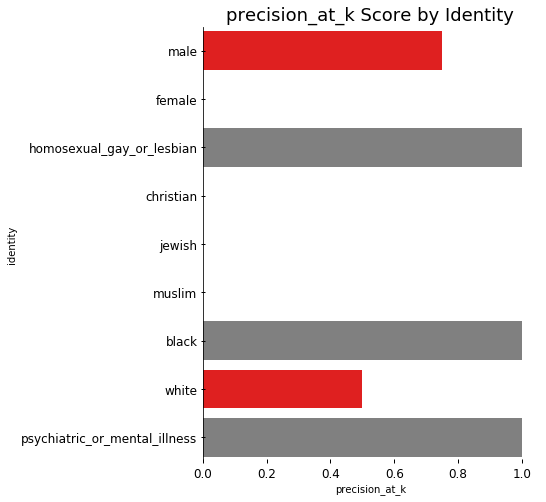

In [56]:
rf.plot_bias(scores, 'precision_at_k')